In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df = pd.read_csv('data/accounts_labelized_20190424.csv')

In [93]:
df[["is_transfer_hub", 'is_witness', 'is_trading_bot']].sum()

is_transfer_hub      61
is_witness           49
is_trading_bot     3518
dtype: int64

In [278]:
df.query('is_transfer_hub == False and is_witness == False and is_trading_bot == False').shape

(243140, 85)

In [3]:
excluded_columns = ['id', 'name', 'vote_voting_account', 'registrar', 'referrer', 'lifetime_referrer', 'is_transfer_hub', 'is_witness', 'is_trading_bot']
only_active_accounts = 'nb_assets_owned >= 0 and lifetime_fees_paid >= 0 and total_ops > 1'
df = df.query(only_active_accounts)
df_numeric_colums = df.drop(excluded_columns, axis='columns')

In [277]:
df.shape

(246729, 85)

In [4]:
#from sklearn.preprocessing import PowerTransformer
#x = PowerTransformer(method='yeo-johnson').fit_transform(x)

from sklearn.preprocessing import FunctionTransformer, StandardScaler
from sklearn.pipeline import Pipeline
log = FunctionTransformer(func=np.log1p, inverse_func=np.expm1, validate=True)
scale = StandardScaler()
pipe = Pipeline([('log', log ),
                 ('scale', scale )])
X = pipe.fit_transform(df_numeric_colums.values)

In [5]:
X = df_numeric_colums.values

In [6]:
y = df['is_trading_bot'].values

In [4]:
def compute_label(row):
    if row.is_witness:
        return 1
    if row.is_trading_bot:
        return 2
    if row.is_transfer_hub:
        return 3
    return 0

y = df.apply (lambda row: compute_label(row), axis=1)

In [52]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=20)

In [76]:
from sklearn import tree
clf = tree.DecisionTreeClassifier(criterion='entropy', max_depth=10, min_samples_leaf=1, min_samples_split=2)

In [279]:
from sklearn.dummy import DummyClassifier
clf = DummyClassifier(strategy='constant', constant=0)

In [8]:
from sklearn.metrics import fbeta_score, make_scorer
scoring = make_scorer(fbeta_score, beta=2, average='micro', labels=[1, 2, 3])

In [78]:
from sklearn.model_selection import cross_val_score, StratifiedKFold


cv = StratifiedKFold(n_splits=4, shuffle=True)
scores = cross_val_score(clf, X, y, cv=cv, scoring=scoring)

print("Accuracy: %0.3f (+/- %0.3f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.939 (+/- 0.010)


In [80]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, stratify=y)

In [81]:
clf = clf.fit(X_train, y_train)

In [83]:
y_pred = clf.predict(X_test)

In [ ]:
unique, counts = np.unique(y_test, return_counts=True)
dict(zip(unique, counts))

In [332]:
unique, counts = np.unique(y_train, return_counts=True)
dict(zip(unique, counts))

{0: 145884, 1: 29, 2: 2087, 3: 37}

In [259]:
unique, counts = np.unique(y_pred, return_counts=True)
dict(zip(unique, counts))

{0: 97342, 1: 17, 2: 1316, 3: 17}

In [329]:
y_test = [0, 0, 0, 1, 2, 3]
y_pred = [0, 0, 1, 1, 2, 3]

In [84]:
from sklearn.metrics import classification_report
target_names = ['default', 'witness', 'trading_bot', 'transfer_hub']
print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

     default       1.00      1.00      1.00    153701
     witness       0.94      0.85      0.89        20
 trading_bot       0.89      0.96      0.93      1407
transfer_hub       0.92      0.92      0.92        24

    accuracy                           1.00    155152
   macro avg       0.94      0.93      0.93    155152
weighted avg       1.00      1.00      1.00    155152



In [85]:
from sklearn.metrics import classification_report
target_names = ['witness', 'trading_bot', 'transfer_hub']
print(classification_report(y_test, y_pred, target_names=target_names, labels=[1, 2, 3]))

              precision    recall  f1-score   support

     witness       0.94      0.85      0.89        20
 trading_bot       0.89      0.96      0.93      1407
transfer_hub       0.92      0.92      0.92        24

   micro avg       0.89      0.96      0.93      1451
   macro avg       0.92      0.91      0.91      1451
weighted avg       0.89      0.96      0.93      1451



In [285]:
from sklearn.metrics import f1_score

f1_score(y_test, y_pred, average='micro', labels=[1, 2, 3])

0.8

In [298]:
from sklearn.metrics import precision_score

precision_score(y_test, y_pred, average='micro', labels=[1, 2, 3])  

0.6666666666666666

In [303]:
from sklearn.metrics import recall_score

recall_score(y_test, y_pred, average='micro', labels=[1, 2, 3]) 

1.0

In [86]:
from sklearn.metrics import fbeta_score

fbeta_score(y_test, y_pred, 2, average='micro', labels=[1, 2, 3])

0.9467897380209042

In [287]:
from sklearn.metrics import accuracy_score

accuracy_score(y_test, y_pred)

0.6666666666666666

In [119]:
from sklearn.metrics import balanced_accuracy_score
balanced_accuracy_score(y_test, y_pred)

0.927100035904767

Confusion matrix, without normalization
[[153535      1    163      2]
 [     2     17      1      0]
 [    51      0   1356      0]
 [     1      0      1     22]]
Normalized confusion matrix
[[9.9892e-01 6.5061e-06 1.0605e-03 1.3012e-05]
 [1.0000e-01 8.5000e-01 5.0000e-02 0.0000e+00]
 [3.6247e-02 0.0000e+00 9.6375e-01 0.0000e+00]
 [4.1667e-02 0.0000e+00 4.1667e-02 9.1667e-01]]


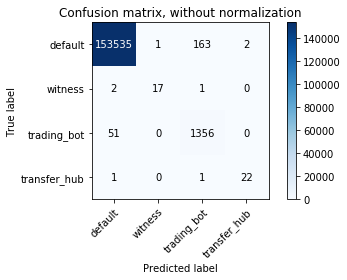

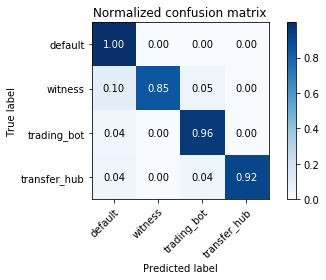

In [88]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

np.set_printoptions(precision=4)

target_names = ['default', 'witness', 'trading_bot', 'transfer_hub']

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=target_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=target_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

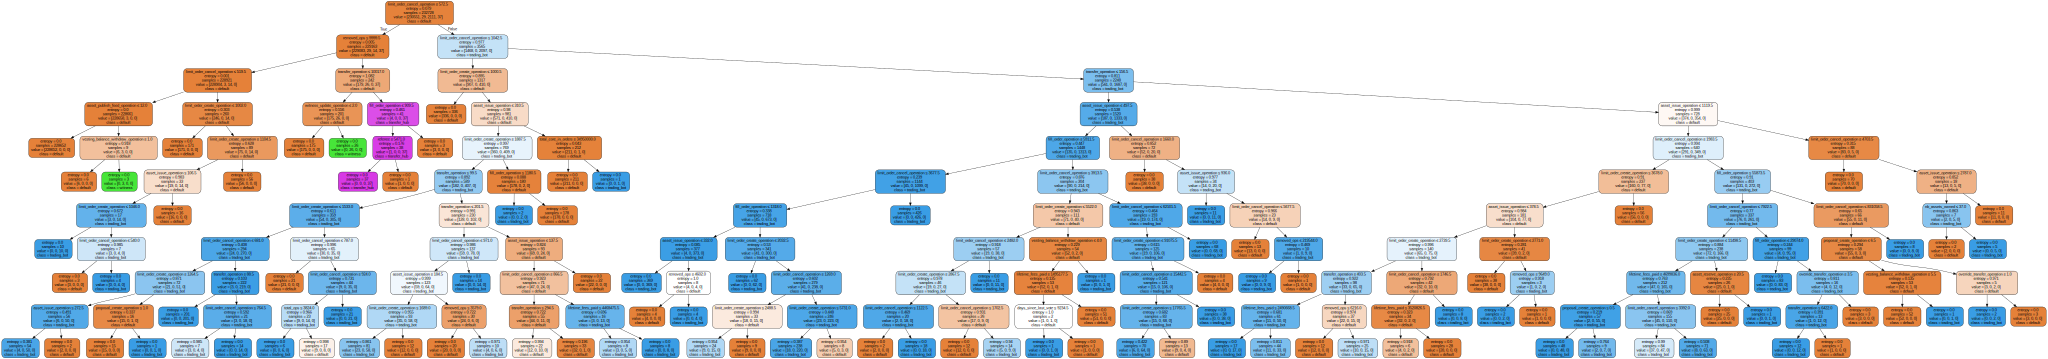

In [163]:
import graphviz 
dot_data = tree.export_graphviz(clf, out_file=None,
                                feature_names=df_numeric_colums.columns,  
                                class_names=['default', 'witness', 'trading_bot', 'transfer_hub'],
                                filled=True, rounded=True,
                                special_characters=True)
graph = graphviz.Source(dot_data) 
#graph.format = 'png'
#graph.render('dtree_render',view=True)
graph

In [45]:
from sklearn.model_selection import validation_curve

def plot_validation_curve(clf, param_name, param_range, cv, scoring):
    train_scores, test_scores = validation_curve(
        clf, X, y, param_name=param_name, param_range=param_range,
        cv=cv, scoring=scoring, n_jobs=-1)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.title("Validation Curve with DecisionTree")
    plt.xlabel(param_name)
    plt.ylabel("Score")
    plt.ylim(0.7, 1.1)
    lw = 2
    plt.plot(param_range, train_scores_mean, label="Training score",
                 color="darkorange", lw=lw)
    plt.fill_between(param_range, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.2,
                     color="darkorange", lw=lw)
    plt.plot(param_range, test_scores_mean, label="Cross-validation score",
                 color="navy", lw=lw)
    plt.fill_between(param_range, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.2,
                     color="navy", lw=lw)
    plt.legend(loc="best")
    plt.show()
    


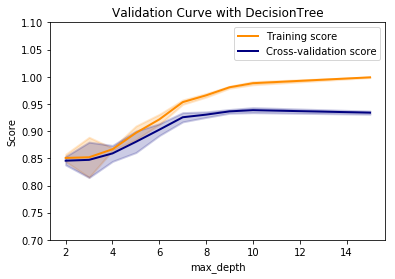

In [64]:
param_name = "max_depth"
param_range = [2, 3, 4, 5, 6, 7, 8, 9, 10, 15]
clf = tree.DecisionTreeClassifier(criterion='gini')
plot_validation_curve(clf, param_name, param_range, cv, scoring)

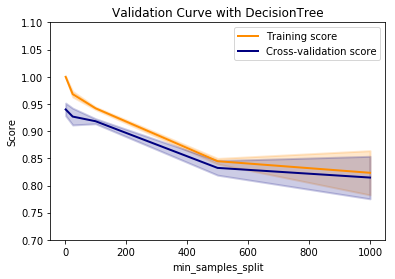

In [58]:
param_name = "min_samples_split"
#param_range = [2, 8, 16, 32, 64, 128, 256]
param_range = [2, 25, 100, 500, 1000]
clf = tree.DecisionTreeClassifier(criterion='entropy')
plot_validation_curve(clf, param_name, param_range, cv, scoring)

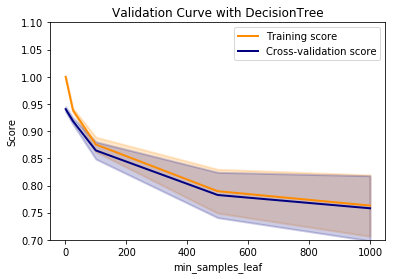

In [59]:
param_name = "min_samples_leaf"
#param_range = [1, 2, 4, 8, 16, 32, 64]
param_range = [1, 25, 100, 500, 1000]
clf = tree.DecisionTreeClassifier(criterion='entropy')
plot_validation_curve(clf, param_name, param_range, cv, scoring)

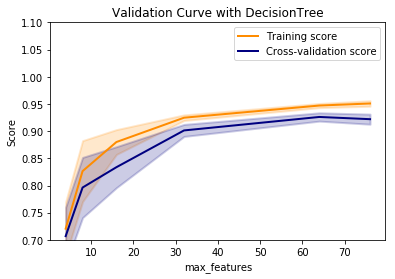

In [49]:
param_name = "max_features"
param_range = [4, 8, 16, 32, 64, 76]
clf = tree.DecisionTreeClassifier(criterion='entropy', min_samples_leaf=20, min_samples_split=25)

plot_validation_curve(clf, param_name, param_range, cv, scoring)

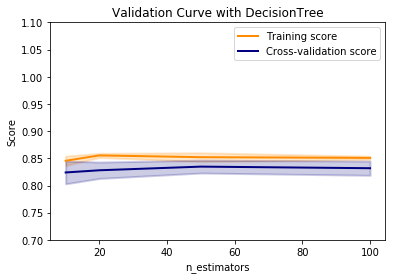

In [53]:
param_name = "n_estimators"
param_range = [10, 20, 50, 100]
clf = RandomForestClassifier(min_samples_leaf=37, min_samples_split=55)
plot_validation_curve(clf, param_name, param_range, cv, scoring)

<module 'matplotlib.pyplot' from '/home/zapata/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py'>

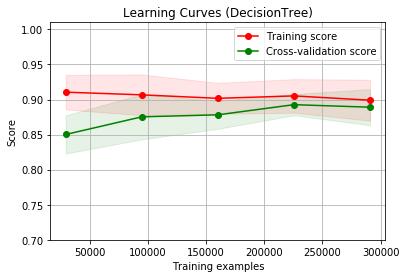

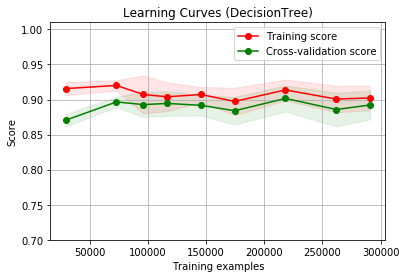

In [27]:
from sklearn.model_selection import learning_curve

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, scoring=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, scoring=scoring, train_sizes=train_sizes, shuffle=True)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt


title = "Learning Curves (DecisionTree)"

train_sizes = np.linspace(.1, 1.0, 5)
plot_learning_curve(clf, title, X, y, ylim=(0.7, 1.01), cv=cv, scoring=scoring, n_jobs=-1, train_sizes=train_sizes)

train_sizes = [0.1, 0.25, 0.33, 0.4, 0.5, 0.6, 0.75, 0.9 ,1.0]
plot_learning_curve(clf, title, X, y, ylim=(0.7, 1.01), cv=cv, scoring=scoring, n_jobs=-1, train_sizes=train_sizes)

In [50]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint
from time import time


# Utility function to report best scores
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

            
param_dist = {"min_samples_split": sp_randint(50, 200),
              "min_samples_leaf": sp_randint(10, 60),
              "criterion": ["gini", "entropy"]}

clf = tree.DecisionTreeClassifier()

n_iter_search = 20
random_search = RandomizedSearchCV(clf, param_distributions=param_dist,
                                   n_iter=n_iter_search, cv=cv, scoring=scoring, n_jobs=-1, iid=False)

start = time()
random_search.fit(X, y)
print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time() - start), n_iter_search))
report(random_search.cv_results_)

RandomizedSearchCV took 124.64 seconds for 20 candidates parameter settings.
Model with rank: 1
Mean validation score: 0.919 (std: 0.010)
Parameters: {'criterion': 'entropy', 'min_samples_leaf': 37, 'min_samples_split': 55}

Model with rank: 2
Mean validation score: 0.917 (std: 0.010)
Parameters: {'criterion': 'entropy', 'min_samples_leaf': 33, 'min_samples_split': 69}

Model with rank: 3
Mean validation score: 0.915 (std: 0.012)
Parameters: {'criterion': 'gini', 'min_samples_leaf': 53, 'min_samples_split': 141}



In [66]:
from sklearn.model_selection import GridSearchCV

param_dist = {"min_samples_split": [2, 10, 50],
              "min_samples_leaf": [1, 10, 30],
              "criterion": ["gini", "entropy"],
              "max_depth": [None, 10]}

clf = tree.DecisionTreeClassifier()
grid_search = GridSearchCV(clf, param_dist, cv=cv, scoring=scoring, n_jobs=-1, iid=False)

start = time()
grid_search.fit(X, y)
print("GridSearchCV took %.2f seconds for %d candidate parameter settings."
      % (time() - start, len(grid_search.cv_results_['params'])))
report(grid_search.cv_results_)

GridSearchCV took 232.65 seconds for 36 candidate parameter settings.
Model with rank: 1
Mean validation score: 0.940 (std: 0.005)
Parameters: {'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2}

Model with rank: 2
Mean validation score: 0.939 (std: 0.004)
Parameters: {'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 10}

Model with rank: 3
Mean validation score: 0.938 (std: 0.010)
Parameters: {'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 10}



In [67]:
grid_search.cv_results_

{'mean_fit_time': array([8.30461872, 8.37465829, 8.20001882, 7.82297134, 7.00666231,
        6.91827047, 7.16643029, 7.67108977, 7.51211929, 7.95661801,
        7.99859655, 8.1888355 , 7.35196781, 7.42544216, 7.12243098,
        7.04863077, 7.18006182, 7.06896454, 4.88227302, 4.66063172,
        4.53226364, 4.5686537 , 4.64864469, 4.54450512, 4.71570337,
        4.67591256, 4.64553672, 4.8086136 , 5.40153491, 5.57383221,
        5.5218901 , 5.32662964, 5.03913647, 5.00150156, 4.82409281,
        4.33025771]),
 'std_fit_time': array([0.23733278, 0.33263218, 0.29935389, 0.40374382, 0.5835303 ,
        0.63144799, 0.51657184, 0.24415674, 0.13992689, 0.48377515,
        0.46235153, 0.38348892, 0.3605296 , 0.3263522 , 0.209495  ,
        0.33730498, 0.31558022, 0.1788153 , 0.31001842, 0.12377432,
        0.14110594, 0.16904784, 0.14311371, 0.06591396, 0.09841586,
        0.07294586, 0.10626974, 0.06897234, 0.32783818, 0.31866566,
        0.22561926, 0.14640121, 0.0763419 , 0.14488245, 0.200

In [73]:
grid_search.cv_results_['mean_test_score'][grid_search.cv_results_['param_min_samples_split'] == 2].mean()

0.9287243731288106

In [75]:
grid_search.cv_results_['mean_test_score'][grid_search.cv_results_['param_min_samples_split'] == 10].mean()

0.9303419642734004

In [162]:
estimator = clf
n_nodes = estimator.tree_.node_count
children_left = estimator.tree_.children_left
children_right = estimator.tree_.children_right
feature = estimator.tree_.feature
threshold = estimator.tree_.threshold


# The tree structure can be traversed to compute various properties such
# as the depth of each node and whether or not it is a leaf.
node_depth = np.zeros(shape=n_nodes, dtype=np.int64)
is_leaves = np.zeros(shape=n_nodes, dtype=bool)
stack = [(0, -1)]  # seed is the root node id and its parent depth
while len(stack) > 0:
    node_id, parent_depth = stack.pop()
    node_depth[node_id] = parent_depth + 1

    # If we have a test node
    if (children_left[node_id] != children_right[node_id]):
        stack.append((children_left[node_id], parent_depth + 1))
        stack.append((children_right[node_id], parent_depth + 1))
    else:
        is_leaves[node_id] = True

print("The binary tree structure has %s nodes and has "
      "the following tree structure:"
      % n_nodes)
for i in range(n_nodes):
    if is_leaves[i]:
        print("%snode=%s leaf node." % (node_depth[i] * "\t", i))
    else:
        print("%snode=%s test node: go to node %s if %s <= %s else to "
              "node %s."
              % (node_depth[i] * "\t",
                 i,
                 children_left[i],
                 df_numeric_colums.columns[feature[i]],
                 threshold[i],
                 children_right[i],
                 ))
print()

# First let's retrieve the decision path of each sample. The decision_path
# method allows to retrieve the node indicator functions. A non zero element of
# indicator matrix at the position (i, j) indicates that the sample i goes
# through the node j.

node_indicator = estimator.decision_path(X_test)

# Similarly, we can also have the leaves ids reached by each sample.

leave_id = estimator.apply(X_test)

# Now, it's possible to get the tests that were used to predict a sample or
# a group of samples. First, let's make it for the sample.

sample_id = 11683
node_index = node_indicator.indices[node_indicator.indptr[sample_id]:
                                    node_indicator.indptr[sample_id + 1]]

print('Rules used to predict sample %s: ' % sample_id)
for node_id in node_index:
    if leave_id[sample_id] == node_id:
        continue

    if (X_test[sample_id, feature[node_id]] <= threshold[node_id]):
        threshold_sign = "<="
    else:
        threshold_sign = ">"

    print("decision id node %s : (X_test[%s, %s] (= %s) %s %s)"
          % (node_id,
             sample_id,
             df_numeric_colums.columns[feature[node_id]],
             X_test[sample_id, feature[node_id]],
             threshold_sign,
             threshold[node_id]))

# For a group of samples, we have the following common node.
sample_ids = [0, 1]
common_nodes = (node_indicator.toarray()[sample_ids].sum(axis=0) ==
                len(sample_ids))

common_node_id = np.arange(n_nodes)[common_nodes]

print("\nThe following samples %s share the node %s in the tree"
      % (sample_ids, common_node_id))
print("It is %s %% of all nodes." % (100 * len(common_node_id) / n_nodes,))

The binary tree structure has 195 nodes and has the following tree structure:
node=0 test node: go to node 1 if limit_order_cancel_operation <= 572.5 else to node 28.
	node=1 test node: go to node 2 if removed_ops <= 9999.5 else to node 19.
		node=2 test node: go to node 3 if limit_order_cancel_operation <= 519.5 else to node 8.
			node=3 test node: go to node 4 if asset_publish_feed_operation <= 12.0 else to node 5.
				node=4 leaf node.
				node=5 test node: go to node 6 if vesting_balance_withdraw_operation <= 1.0 else to node 7.
					node=6 leaf node.
					node=7 leaf node.
			node=8 test node: go to node 9 if limit_order_create_operation <= 1002.0 else to node 10.
				node=9 leaf node.
				node=10 test node: go to node 11 if limit_order_create_operation <= 1104.5 else to node 18.
					node=11 test node: go to node 12 if asset_issue_operation <= 106.5 else to node 17.
						node=12 test node: go to node 13 if limit_order_create_operation <= 1046.0 else to node 14.
							node=13 le

In [152]:
np.where(y_test == 1)

(array([  5145,  11683,  13978,  60619,  67610,  75638,  76720,  81122,
         89110,  98831, 102944, 111884, 116242, 117190, 117381, 124036,
        139100, 148626, 151724, 152489]),)

In [159]:
y_test.values[11683]

1

In [161]:
X_test[11683, 45]

0

In [146]:
df.columns

Index(['id', 'name', 'auths_owner_count', 'auths_active_count',
       'vote_num_witness', 'vote_num_committee', 'vote_num_votes',
       'vote_voting_account', 'whitelisting_accounts', 'blacklisting_accounts',
       'whitelisted_accounts', 'blacklisted_accounts', 'total_ops',
       'removed_ops', 'lifetime_fees_paid', 'total_core_in_orders',
       'core_in_balance', 'pending_fees', 'pending_vested_fees',
       'days_since_last_vote', 'nb_assets_owned', 'registrar', 'referrer',
       'lifetime_referrer', 'transfer_operation',
       'limit_order_create_operation', 'limit_order_cancel_operation',
       'call_order_update_operation', 'fill_order_operation',
       'account_create_operation', 'account_update_operation',
       'account_whitelist_operation', 'account_upgrade_operation',
       'account_transfer_operation', 'asset_create_operation',
       'asset_update_operation', 'asset_update_bitasset_operation',
       'asset_update_feed_producers_operation', 'asset_issue_operatio

In [133]:
df.loc[y_test[y_test == 1].index]

id                     name  auths_owner_count  \
152639  1.2.152739                 blckchnd                  2   
3184      1.2.3284               harvey-xts                  1   
31710    1.2.31810                   rnglab                  1   
5904      1.2.6004               maqifrnswa                  1   
31790    1.2.31890                roadscape                  1   
24910    1.2.25010                     bhuz                  1   
95189    1.2.95289               dragonball                  1   
67         1.2.167                      fox                  1   
89192    1.2.89292  bts-bitshares-argentina                  1   
13935    1.2.14035              xn-delegate                  3   
632415  1.2.632515            winex.witness                  1   
23625    1.2.23725                  bitcube                  1   
4852      1.2.4952                   abc123                  1   
711028  1.2.711128                clockwork                  1   
130110  1.2.130210              witness.yao                  1   
964        1.2.964                 jerryliu                  3   
814441  1.2.814541                   bangzi                  1   
166342  1.2.166442                    sc-ol                  1   
30789    1.2.30889        delegate-1.lafona                  1   
91687    1.2.91787              verbaltech2                  1   

        auths_active_count  vote_num_witness  vote_num_committee  \
152639                   1                21                   4   
3184                     1                 0                   0   
31710                    1                21                  11   
5904                     1                 3                   0   
31790                    1                 2                   1   
24910                    1                14                  17   
95189                    1                 0                   0   
67                       1                 0                   0   
89192                    4                 0                   0   
13935                    1                 0                   0   
632415                   1                 0                   0   
23625                    1                 0                   0   
4852                     1                 0                   0   
711028                   2                30                  13   
130110                   1                 1                   0   
964                      1                20                  10   
814441                   1                82                  17   
166342                   1                 6                   3   
30789                    1                 0                   0   
91687                    1                 0                   0   

        vote_num_votes vote_voting_account  whitelisting_accounts  \
152639              31               1.2.5                      0   
3184                 0               1.2.5                      0   
31710               43               1.2.5                      0   
5904                 5               1.2.5                      0   
31790                3             1.2.282                      1   
24910               39               1.2.5                      1   
95189                0               1.2.5                      0   
67                   1             1.2.282                      1   
89192                0               1.2.5                      0   
13935                1               1.2.5                      0   
632415               1               1.2.5                      0   
23625                0               1.2.5                      0   
4852                 1               1.2.5                      0   
711028              61               1.2.5                      0   
130110               1             1.2.285                      0   
964                 31             1.2.121                      1   
814441             113     